### Full Name : Amirparsa Bahrami
### Student Number : 401101332


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    # Z-score normalization with mean and std for the MNIST dataset (single channel)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0), (1))  # mean and std from MNIST dataset
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
def explore_data(data_loader, num_samples=10):
    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Plot sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()

    # Plot label distribution
    all_labels = []
    for _, lbls in data_loader:
        all_labels += lbls.tolist()

    plt.hist(all_labels, bins=10, edgecolor='black')
    plt.title("Label Distribution")
    plt.xlabel("Label")
    plt.ylabel("Frequency")
    plt.show()

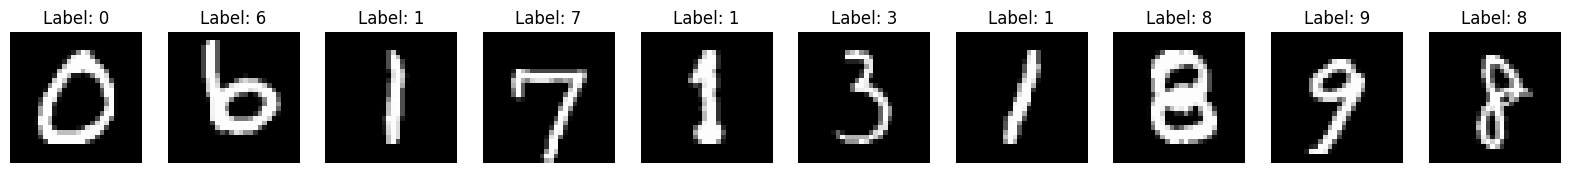

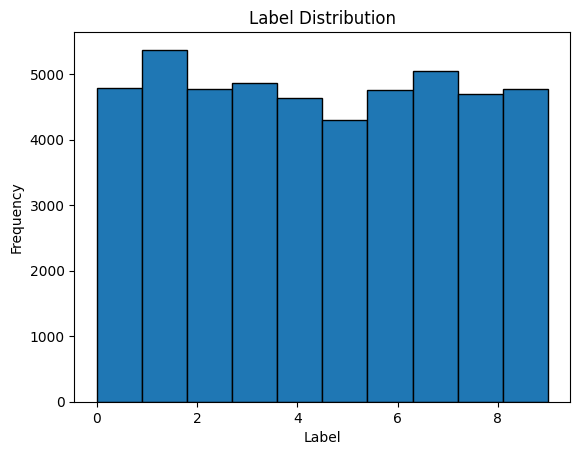

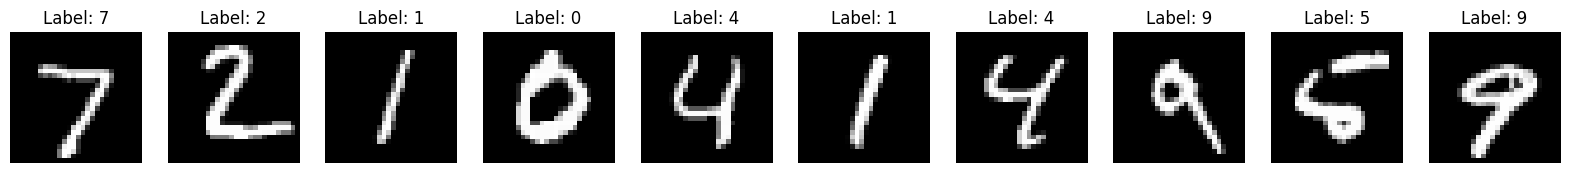

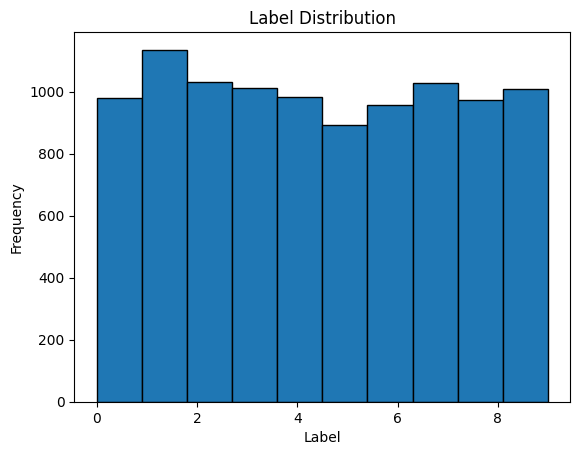

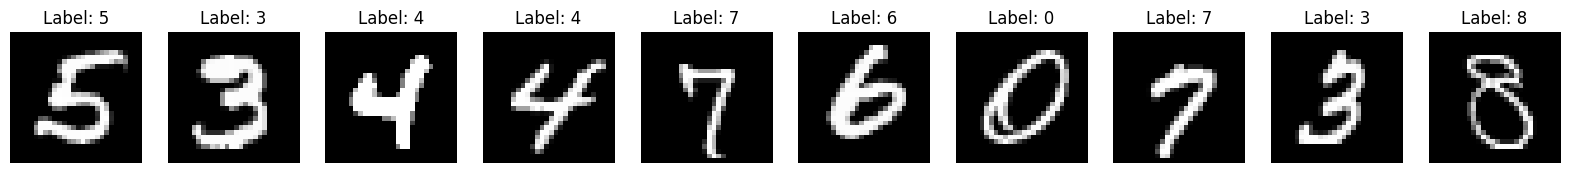

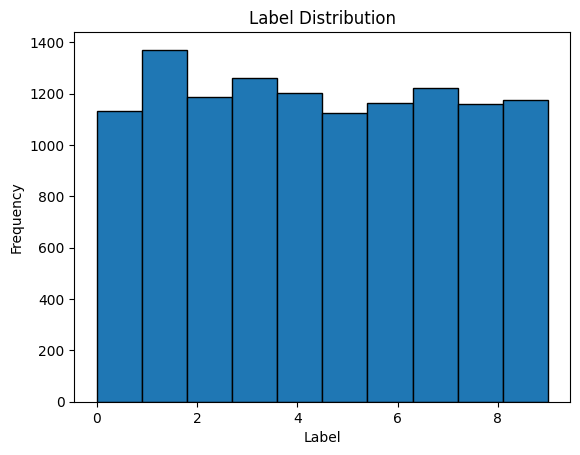

In [ ]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [ ]:
def prepare_data_for_cart(data_loader):
    X, y = [], []
    for images, labels in data_loader:
        X.append(images.view(images.size(0), -1).numpy())  # Flatten images
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)

In [ ]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

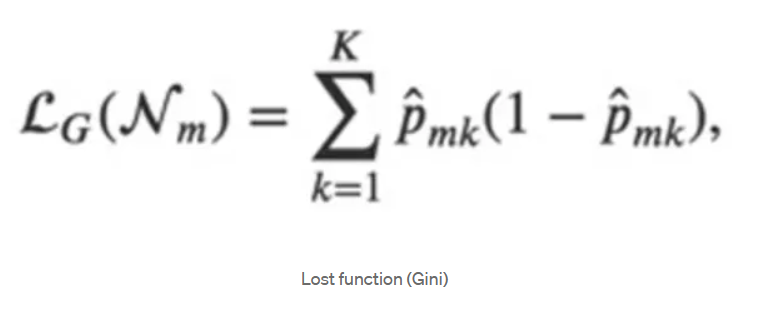

In [ ]:
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2, num_classes=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.num_classes = num_classes
        self.root = None

    def fit(self, X, y):
        # Set the number of classes based on y if not provided
        if self.num_classes is None:
            self.num_classes = len(np.unique(y))
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Stop splitting if max depth is reached or samples are too small
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(set(y)) == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best feature and threshold to split on
        feature, threshold = self._find_best_split(X, y)

        if feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Split data
        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)

    def _find_best_split(self, X, y):
        best_gini = float('inf')  # Initialize Gini as a large number
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gini = self._calculate_gini_split(X[:, feature], y, threshold)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini_split(self, feature_values, y, threshold):
        left_mask = feature_values < threshold
        right_mask = feature_values >= threshold

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return float('inf')

        left_gini = self._gini_impurity(y[left_mask])
        right_gini = self._gini_impurity(y[right_mask])
        n = len(y)
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)

        weighted_gini = (n_left / n) * left_gini + (n_right / n) * right_gini
        return weighted_gini

    def _gini_impurity(self, y):
        """Calculate Gini Impurity based on the provided formula"""
        m = len(y)
        if m == 0:
            return 0

        class_counts = np.bincount(y, minlength=self.num_classes)  # Count occurrences of each class
        p_mk = class_counts / m  # Probabilities for each class

        # Gini Impurity calculation: sum(p_mk * (1 - p_mk))
        gini = np.sum(p_mk * (1 - p_mk))
        return gini

    def _most_common_label(self, y):
        """Return the most common label in the dataset"""
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)




## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

CART accuracy: 69.68%
scikit-learn accuracy: 69.69%


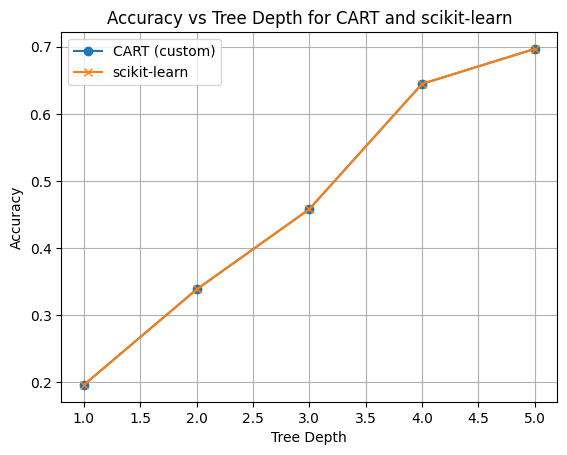

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Step 1: Train your CART implementation
tree = DecisionTree_CART(max_depth=5)
tree.fit(X_train, y_train)

# Step 2: Evaluate your model's performance
predictions_cart = tree.predict(X_test)
cart_accuracy = accuracy_score(y_test, predictions_cart)
print(f"CART accuracy: {cart_accuracy * 100:.2f}%")

# Step 3: Train scikit-learn's DecisionTreeClassifier on the same data
sklearn_tree = DecisionTreeClassifier(max_depth=5)
sklearn_tree.fit(X_train, y_train)

# Step 4: Evaluate sklearn's model performance
predictions_sklearn = sklearn_tree.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, predictions_sklearn)
print(f"scikit-learn accuracy: {sklearn_accuracy * 100:.2f}%")

# Step 5: Plot accuracy as a function of tree depth
depths = range(1, 6)
cart_accuracies = []
sklearn_accuracies = []

for depth in depths:
    # Train and evaluate CART implementation
    cart_tree = DecisionTree_CART(max_depth=depth)
    cart_tree.fit(X_train, y_train)
    cart_preds = cart_tree.predict(X_test)
    cart_accuracies.append(accuracy_score(y_test, cart_preds))

    # Train and evaluate scikit-learn DecisionTreeClassifier
    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_preds = sklearn_tree.predict(X_test)
    sklearn_accuracies.append(accuracy_score(y_test, sklearn_preds))

# Plotting the results
plt.plot(depths, cart_accuracies, label='CART (custom)', marker='o')
plt.plot(depths, sklearn_accuracies, label='scikit-learn', marker='x')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth for CART and scikit-learn')
plt.legend()
plt.grid(True)
plt.show()

## Question
What is the difference between ID3 and CART algorithm

ID3 (Iterative Dichotomiser 3) and CART (Classification and Regression Trees) are both decision tree algorithms used for classification and regression tasks. However, they differ in their tree-building strategies, splitting criteria, and handling of certain aspects of data. Here’s a comparison:

1. Splitting Criteria:

	•	ID3: Uses information gain as the splitting criterion, which is based on the concept of entropy. It selects the attribute that provides the highest information gain at each node.
	•	CART: Uses Gini impurity (for classification) or mean squared error (MSE) (for regression) as its splitting criterion. CART chooses the split that minimizes the impurity or variance in the resulting subsets.

2. Type of Trees:

	•	ID3: Primarily designed for classification tasks. It doesn’t directly handle regression tasks.
	•	CART: Can handle both classification and regression tasks. In classification, it produces a decision tree; in regression, it produces a regression tree.

3. Handling of Continuous Variables:

	•	ID3: Handles only categorical variables by default. It can handle continuous variables, but requires discretization beforehand (i.e., splitting them into categories).
	•	CART: Natively handles both continuous and categorical variables. For continuous variables, CART finds optimal split points during tree construction.

4. Tree Structure:

	•	ID3: Generates a multiway tree, meaning nodes can have multiple children depending on how many possible values a feature can take.
	•	CART: Generates a binary tree, meaning every internal node has only two children (yes/no or true/false decisions).

5. Pruning:

	•	ID3: Does not natively support pruning. To prevent overfitting, additional strategies (like post-pruning) need to be applied separately.
	•	CART: Includes pruning mechanisms. It uses cost-complexity pruning to reduce overfitting, cutting back the tree based on a trade-off between tree complexity and accuracy.

6. Output:

	•	ID3: Outputs a tree with class labels at the leaves.
	•	CART: For classification, CART outputs a tree with class probabilities at the leaves, and for regression, it outputs a continuous value.

7. Algorithm Type:

	•	ID3: Developed earlier (by Ross Quinlan in 1986), and is simpler but limited to certain types of tasks.
	•	CART: Developed later (by Breiman et al. in 1984) and is more versatile, used widely in modern machine learning due to its support for both classification and regression.

Summary:

	•	ID3: Focuses on classification, uses information gain (entropy) for splitting, and does not handle continuous data natively. It generates multiway trees and does not include built-in pruning.
	•	CART: Supports both classification and regression, uses Gini impurity or MSE for splitting, handles continuous data, generates binary trees, and includes built-in pruning techniques.

CART is more versatile and widely used today, while ID3 is mainly of historical interest or for simpler classification tasks.